# 1. 구글드라이브

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd drive/MyDrive/[한이음] 적대적 AI 공격에 대한 인공지능 보안기술 연구/3. 소스코드/GTSRB

/content/drive/MyDrive/[한이음] 적대적 AI 공격에 대한 인공지능 보안기술 연구/3. 소스코드/GTSRB


# 2. import & 데이터셋

In [3]:
import pandas as pd
import numpy as np
import natsort

import os
import pathlib
import matplotlib.pyplot as plt

from PIL import Image # 파이썬 이미지 처리 pillow 라이브러리
import cv2 #영상처리에 사용하는 오픈소스 라이브러리, 컴퓨터가 사람 눈처럼 인식할 수 있게 처리
from tensorflow.keras.preprocessing import image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator #imagedatagenerater는 이미지를 학습시킬 때 학습 데이터의 양이 적을 경우 학습데이터를 조금씩 변형 시켜서 학습데이터의 양을 늘리는 방식중 하나
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img, load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data

import torchvision.utils
from torchvision import models
import torchvision.datasets as dsets
import torchvision.transforms as transforms

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from tqdm.auto import tqdm

In [4]:
#난수 랜덤성 고정
np.random.seed(42)

In [5]:
# # Set Args
# use_cuda = True
# device = torch.device("cuda" if use_cuda else "cpu")

In [6]:
metainfo = pd.read_csv("Meta.csv")
traininfo = pd.read_csv("Train.csv")
testinfo = pd.read_csv("Test.csv")

In [7]:
class GTSRB_test:
  def __init__(self):
        
    # 실제 사용할 label 12개
    valid_labels = [3, 7, 9, 10, 11, 12, 13, 17, 18, 25, 35, 38]
    valid_labels_12 = [i for i in range(len(valid_labels))] # [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

    # 우선 CSV에서 모든 ClassId를 불러옴
    all_classids = list(testinfo['ClassId']) # len = 12630
    self.all_classids = all_classids

    # 불러온 ClassId 중 valid_label인 요소들의 index를 구함
    valid_idxs = []
    idx1 = 0
    for all_classid in all_classids:
      if all_classid in valid_labels:
        valid_idxs.append(idx1)
      idx1 += 1 # valid_idxs의 각 요소가 idx. 해당 idx의 이미지만 유효
    self.valid_idxs = valid_idxs

    # Test 데이터와 label을 불러옴
    imgs_path = "Test"
    test_data = []
    test_label_38 = [] # valid한 label이나, 3~38 범위 (이후 0~11 범위로 각각 변경해줄 것) (아래 쪽 코드에서...)

    fnames = natsort.natsorted(os.listdir(imgs_path))
    for valid_idx in valid_idxs: # valid 한 index의 이미지만 불러와 test_data로 append -> test image dataset!
      im = Image.open(imgs_path + '/' + fnames[valid_idx])
      im = np.array(im.resize((32,32)))
      test_data.append(im)
      test_label_38.append(all_classids[valid_idx]) # 해당 이미지의 label (BUT 3~38)
    test_data = np.array(test_data)
    test_label_38 = np.array(test_label_38)

    # valid label만 잘 담겼는지 확인하는 코드
    unique = sorted(list(set(test_label_38)))
    self.validcheck = valid_labels == unique

    # label 3~38 -> 0~11
    test_label = - np.ones(len(test_label_38))
    for valid_label_12 in valid_labels_12:
      ii = np.where(test_label_38 == valid_labels[valid_label_12])
      idxs1 = ii[0]
      for idx1 in idxs1:
        test_label[idx1] = valid_label_12
    test_label_1H = to_categorical(test_label)

    self.x_test = test_data
    self.y_test = test_label
    self.y_test_1H = test_label_1H

    @staticmethod
    def print():
      return "GTSRB_test"

In [8]:
data_test = GTSRB_test()

============ Test 데이터 설명 ============

valid한 label만 잘 담겼는지 check : True


test 이미지 : data_test.x_test ~~~~~~~~~~
shape :  (6180, 32, 32, 3)
test 라벨 : data_test.y_test ~~~~~~~~~~~
shape :  (6180,)
test 원핫 : data_text.y_test_1H ~~~~~~~~
shape :  (6180, 12)

하나의 이미지와 라벨 확인
0


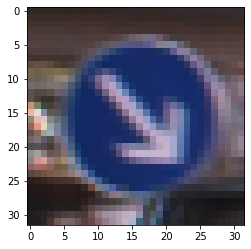

In [15]:
print("============ Test 데이터 설명 ============\n")
print("valid한 label만 잘 담겼는지 check :", data_test.validcheck)
print("\n")
print("test 이미지 : data_test.x_test ~~~~~~~~~~")
print("shape : ", data_test.x_test.shape)
print("test 라벨 : data_test.y_test ~~~~~~~~~~~")
print("shape : ", data_test.y_test.shape)
print("test 원핫 : data_text.y_test_1H ~~~~~~~~")
print("shape : ", data_test.y_test_1H.shape)

print("\n하나의 이미지와 라벨 확인")
print(np.argmax(data_test.y_test[0]))
plt.imshow(data_test.x_test[0])

# 3. PGD attack

In [ ]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def PGD_perturb(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    input_img = tf.reshape(input_image,[1,32,32,3])
    prediction = model(input_img)
    loss = loss_object(input_label, prediction)

  # 입력 이미지에 대한 손실 함수의 기울기를 구합니다.
  gradient = tape.gradient(loss, input_image)
  # 왜곡을 생성하기 위해 그래디언트의 부호를 구합니다.
  signed_grad = tf.sign(gradient)
  return signed_grad

In [ ]:
x_nat = data_test.x_test[120]
y = data_test.y_test[120]



# loss : 일단 cw로.
label_mask = tf.one_hot(data_test.y_test, 12, on_value=1.0, off_value=0.0, dtype=tf.float32)
correct_logit = tf.reduce(sum(label_mask))


with tf.variable_scope('costs'):
  y_xent = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=self.pre_softmax, labels=y)
  xent = tf.reduce_sum(y_xent, name='y_xent')



loss = xent
self_grad = tf.gradients(loss,x)
epsilon = 8.0

x = x_nat + np.random.uniform(-0.02, 0.02, x_nat.shape)
x = np.clip(x, 0, 255)

for i in range(40):
  grad = sess.run(self_grad, feed_dict={x : x, y : y})
  
  x = np.add(x, 0.01 * np.sign(grad), out=x, casting='unsafe')
  x = np.clip(x, x_nat - epsilon, x_nat + epsilon)
  x = np.clip(x,0,255)


In [ ]:
plt.imshow(x_nat)

In [ ]:
plt.imshow(x)